In [87]:
!pip install azure-keyvault-secrets==4.7.0
!pip install azure-identity
!pip install azure-mgmt-resource
!pip install Flask
!pip install pydicom

In [88]:
!pip install pydicom

In [1]:
import requests
import pydicom
from pathlib import Path
from urllib3.filepost import encode_multipart_formdata, choose_boundary

Configure user-defined variables

In [2]:
dicom_service_name = "demo-dicom-service"
path_to_dicoms_dir = r"C:\Users\Asus\dicomservice\dicom-files"

Service_URL= 'https://dicomdemogroup-demo-dicom-service.dicom.azurehealthcareapis.com'
version=1

base_url = f"{Service_URL}/v{version}"

study_uid = "1.2.826.0.1.3680043.8.498.13230779778012324449356534479549187420"; #StudyInstanceUID for all 3 examples
series_uid = "1.2.826.0.1.3680043.8.498.45787841905473114233124723359129632652"; #SeriesInstanceUID for green-square and red-triangle
instance_uid = "1.2.826.0.1.3680043.8.498.47359123102728459884412887463296905395"; #SOPInstanceUID for red-triangle

In [91]:
print(base_url)
print(path_to_dicoms_dir)
print(dicom_service_name)

https://dicomdemogroup-demo-dicom-service.dicom.azurehealthcareapis.com/v1
C:\Users\Asus\dicomservice\dicom-files
demo-dicom-service



Authenticate to Azure and get a token

In [92]:
%pip install azure-identity

Note: you may need to restart the kernel to use updated packages.


In [9]:
token = "*****"

In [10]:
bearer_token = f'Bearer {token}'
print(bearer_token)

Bearer eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsIng1dCI6IjVCM25SeHRRN2ppOGVORGMzRnkwNUtmOTdaRSIsImtpZCI6IjVCM25SeHRRN2ppOGVORGMzRnkwNUtmOTdaRSJ9.eyJhdWQiOiJodHRwczovL2RpY29tLmhlYWx0aGNhcmVhcGlzLmF6dXJlLmNvbSIsImlzcyI6Imh0dHBzOi8vc3RzLndpbmRvd3MubmV0L2FmMmMwNzM0LWNiNDItNDY0Zi1iNmJmLTJhMjQxYjZhZGE1Ni8iLCJpYXQiOjE3MDU5MzA5NTgsIm5iZiI6MTcwNTkzMDk1OCwiZXhwIjoxNzA1OTM2NTI3LCJhY3IiOiIxIiwiYWlvIjoiQVRRQXkvOFZBQUFBSTdCVUlEbml0cGp5d08yeTlXRjVPN1Z0TU5MUmpSdG5CVXJEOXNNMTIxVzV4eFRoNHBxNVdhSUhCL2FOQXJGaiIsImFwcGlkIjoiMDRiMDc3OTUtOGRkYi00NjFhLWJiZWUtMDJmOWUxYmY3YjQ2IiwiYXBwaWRhY3IiOiIwIiwiZ2l2ZW5fbmFtZSI6Imhhc2FuYWguMTAxMDUiLCJpcGFkZHIiOiIyMC4xOTUuMC4xMjUiLCJuYW1lIjoiaGFzYW5haC4xMDEwNSIsIm9pZCI6IjZhOGNiNzUzLWIxZDQtNDY4Zi1hZTc5LTkwODk3NTkwZjRmMCIsInB1aWQiOiIxMDAzMjAwMEM1QUEyQzUwIiwicmgiOiIwLkFWTUFOQWNzcjBMTFQwYTJ2eW9rRzJyYVZyOGw1M1hPWnVwTW01cGNUS3JsZnpOVEFGOC4iLCJzY3AiOiJ1c2VyX2ltcGVyc29uYXRpb24iLCJzdWIiOiJ1M2JpVEV1dTBsX3NQMV9XSUFtdmp3ODNyMEZGN1RfVTRVNVg4ZnFnRTBrIiwidGlkIjoiYWYyYzA3MzQtY2I0Mi00NjRmLWI2YmYt


Create supporting methods to support multipart\related

In [11]:
def encode_multipart_related(fields, boundary=None):
    if boundary is None:
        boundary = choose_boundary()

    body, _ = encode_multipart_formdata(fields, boundary)
    content_type = str('multipart/related; boundary=%s' % boundary)

    return body, content_type

In [12]:
client = requests.session()

In [13]:
#verify
headers = {"Authorization":bearer_token}
url= f'{base_url}/changefeed'

response = client.get(url,headers=headers)
if (response.status_code != 200):
    print('Error! Likely not authenticated!')

In [14]:
#upload blue-circle.dcm
filepath = Path(path_to_dicoms_dir).joinpath('blue-circle.dcm')

# Read through file and load bytes into memory 
with open(filepath,'rb') as reader:
    rawfile = reader.read()
files = {'file': ('dicomfile', rawfile, 'application/dicom')}

#encode as multipart_related
body, content_type = encode_multipart_related(fields = files)

headers = {'Accept':'application/dicom+json', "Content-Type":content_type, "Authorization":bearer_token}

url = f'{base_url}/studies'
response = client.post(url, body, headers=headers, verify=False)
response

<Response [409]>

WADO

In [15]:
#Retrieve all instances within a study
url = f'{base_url}/studies/{study_uid}'
headers = {'Accept':'multipart/related; type="application/dicom"; transfer-syntax=*', "Authorization":bearer_token}

response = client.get(url, headers=headers) #, verify=False)
response

<Response [200]>

In [101]:
%pip install requests-toolbelt

Note: you may need to restart the kernel to use updated packages.


In [16]:
import requests_toolbelt as tb
from io import BytesIO

mpd = tb.MultipartDecoder.from_response(response)
for part in mpd.parts:
    # Note that the headers are returned as binary!
    print(part.headers[b'content-type'])
    
    # You can convert the binary body (of each part) into a pydicom DataSet
    #   And get direct access to the various underlying fields
    dcm = pydicom.dcmread(BytesIO(part.content))
    print(dcm.PatientName)
    print(dcm.SOPInstanceUID)

b'application/dicom; transfer-syntax=1.2.840.10008.1.2.1'
Anony Mous
1.2.826.0.1.3680043.8.498.12714725698140337137334606354172323212
b'application/dicom; transfer-syntax=1.2.840.10008.1.2.1'
Anony Mous
1.2.826.0.1.3680043.8.498.47359123102728459884412887463296905395
b'application/dicom; transfer-syntax=1.2.840.10008.1.2.1'
Anony Mous
1.2.826.0.1.3680043.8.498.13273713909719068980354078852867170114


In [103]:
#Retrieve metadata of all instances in study
url = f'{base_url}/studies/{study_uid}/metadata'
headers = {'Accept':'application/dicom+json', "Authorization":bearer_token}

response = client.get(url, headers=headers) #, verify=False)
response

<Response [200]>

In [17]:
#Retrieve all instances within a series
url = f'{base_url}/studies/{study_uid}/series/{series_uid}'
headers = {'Accept':'multipart/related; type="application/dicom"; transfer-syntax=*', "Authorization":bearer_token}

response = client.get(url, headers=headers) #, verify=False)
response

<Response [200]>

In [18]:
mpd = tb.MultipartDecoder.from_response(response)
for part in mpd.parts:
    # Note that the headers are returned as binary!
    print(part.headers[b'content-type'])
    
    # You can convert the binary body (of each part) into a pydicom DataSet
    #   And get direct access to the various underlying fields
    dcm = pydicom.dcmread(BytesIO(part.content))
    print(dcm.PatientName)
    print(dcm.SeriesInstanceUID)

b'application/dicom; transfer-syntax=1.2.840.10008.1.2.1'
Anony Mous
1.2.826.0.1.3680043.8.498.45787841905473114233124723359129632652
b'application/dicom; transfer-syntax=1.2.840.10008.1.2.1'
Anony Mous
1.2.826.0.1.3680043.8.498.45787841905473114233124723359129632652


In [19]:
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 242
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.47359123102728459884412887463296905395
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.27364069006046809016231924679252811609
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.4.2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.368004

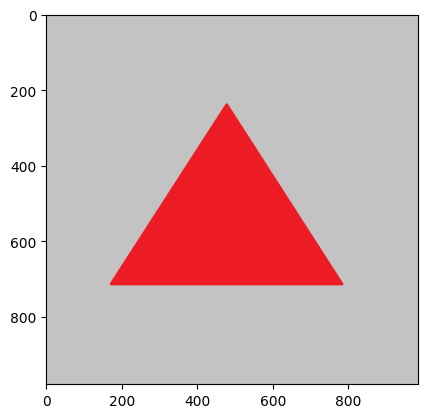

In [22]:
import matplotlib.pyplot as plt

plt.imshow(dcm.pixel_array)

In [ ]:
#retrieve metadata of all instances in series
url = f'{base_url}/studies/{study_uid}/series/{series_uid}/metadata'
headers = {'Accept':'application/dicom+json', "Authorization":bearer_token}

response = client.get(url, headers=headers) #, verify=False)
response

<Response [200]>

In [25]:
#Retrieve a single instance within a series of a study
url = f'{base_url}/studies/{study_uid}/series/{series_uid}/instances/{instance_uid}'
headers = {'Accept':'application/dicom; transfer-syntax=*', "Authorization":bearer_token}

response = client.get(url, headers=headers) #, verify=False)
response

<Response [200]>

In [ ]:
#Retrieve metadata of a single instance within a series of a study
url = f'{base_url}/studies/{study_uid}/series/{series_uid}/instances/{instance_uid}/metadata'
headers = {'Accept':'application/dicom+json', "Authorization":bearer_token}

response = client.get(url, headers=headers) #, verify=False)
response

<Response [200]>

In [ ]:
#Retrieve one or more frames from a single instance
url = f'{base_url}/studies/{study_uid}/series/{series_uid}/instances/{instance_uid}/frames/1'
headers = {'Accept':'multipart/related; type="application/octet-stream"; transfer-syntax=*', "Authorization":bearer_token}

response = client.get(url, headers=headers) #, verify=False)
response

<Response [200]>

QIDO

In [ ]:
def encode_multipart_related(fields, boundary=None):
    if boundary is None:
        boundary = choose_boundary()

    body, _ = encode_multipart_formdata(fields, boundary)
    content_type = str('multipart/related; boundary=%s' % boundary)

    return body, content_type

In [23]:
url = f'{base_url}/studies'
headers = {'Accept':'application/dicom+json', "Authorization":bearer_token}
params = {'StudyInstanceUID':study_uid}

response = client.get(url, headers=headers, params=params) #, verify=False)
response

<Response [200]>